# 20CRv3 Spatial analysis - temperature
This notebook analyses monthly temperature anomalies and produces spatial plots for Australia and the globe using CMIP6 historical model output (43 models).  

Notebook last updated on 23 May 2023 by Kate Bongiovanni.

In [1]:
# import relevant libraries
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload 
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs 
import dask.diagnostics 

In [2]:
# define path for files
path = '/g/data/w40/W48_GDATA_MOVED/kb6999'

In [3]:
# import custom functions
import sys 
sys.path.append(f'{path}/Masters_paper') 
import GRL_functions as func

In [4]:
# create a list of member names excluding member 70 cos that file is problematic 
members = [*range(1,70),*range(71,81)]

Read in 20CRv3 temperature and precipitation files and combine the individual years into one array for each member (79 members). 

In [5]:
# read in raw 20CR temperature data (accessible from https://portal.nersc.gov/archive/home/projects/incite11/www/20C_Reanalysis_version_3/everymember_anal_netcdf/subdaily)
tmp_paths = [f"{path}/Reanalysis/20CR_TMP_raw_members/R_raw_Glob_TMP{m:02d}.nc" for m in members]
ds_tmp = xr.open_mfdataset(tmp_paths, combine='nested', concat_dim='member', chunks={'time': 100})
ds_tmp.coords['member'] = members

In [6]:
# rename the temperature variable
reanal_r = xr.Dataset({'tmp': ds_tmp.TMP})
# convert into degrees Celsius
reanal_r['tmp'] = reanal_r.tmp-273

In [7]:
# reverse the latitude axis so it goes from -90 to 90 degrees
reanal = reanal_r.reindex(lat=list(reversed(reanal_r.lat)))

In [8]:
# area weighting 
reanal_w = reanal*np.cos(reanal.lat*(np.pi/180))
reanal_w

<xarray.Dataset>
Dimensions:  (time: 1992, lon: 512, lat: 256, member: 79)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
  * lon      (lon) float32 0.0 0.703 1.406 2.109 ... 357.1 357.8 358.5 359.2
  * lat      (lat) float32 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
Data variables:
    tmp      (member, time, lat, lon) float32 dask.array<chunksize=(1, 100, 256, 512), meta=np.ndarray>

In [9]:
# set the chunk size for how the data is handled
reanal_w = reanal_w.chunk(chunks={'time': 100})

In [10]:
# select out the years around Krakatau, plus 30 years of climatology (1850-1879)
reanal_w = reanal_w.sel(time = slice('1850-01', '1889-12'))

### Anomalies

In [11]:
# use functions to calculate the seasonal anomalies for the globe
seasonal_anom_glob = func.seasonal_anomaly(reanal_w, '1850', '1879')

In [12]:
# take the multi-member mean
mmm_mon_Glob = seasonal_anom_glob.mean(dim=('member'))

In [13]:
# select out dates around Krakatau eruption 
K_mmm_mon_Glob = mmm_mon_Glob.sel(seasonyear = slice('1850','1890'))

In [14]:
# save global anomalies into a netcdf
file_path = f'{path}/Masters_paper/20CR_seasonal_anom/R_season_anom_TMP_glob.nc'
# if they have already been saved as a netcdf, then nothing happens here
if not os.path.exists(file_path):
    K_mmm_mon_Glob.to_netcdf(f'{file_path}')

In [15]:
# open the newly saved anomalies
K_mmm_mon_Glob = xr.open_dataset(f'{file_path}')

In [16]:
# select out gridbox over Australia
K_mmm_mon_Aus = K_mmm_mon_Glob.sel(lat=slice(-45,-10), lon=slice(110,155))

## Figures

In [17]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [18]:
# dates and title for eruption and 3 times after
# K_dates winter
K_dates_w = [1883, 1884, 1885, 1886, 1887]
# K_dates_summer
K_dates_s = [1882, 1883, 1884, 1885, 1886]

In [19]:
# alternative short titles
# winter titles
titles_w = func.seasonal_title_short(K_dates_w, 'winter', 'JJA')
 # summer titles 
titles_s = func.seasonal_title_short(K_dates_s, 'summer', 'DJF')
titles_s

['pre-eruption (DJF 1882)',
 '1st summer (DJF 1883)',
 '2nd summer (DJF 1884)',
 '3rd summer (DJF 1885)',
 '4th summer (DJF 1886)']

In [20]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [21]:
# set the mod max for the colour bars
cmax_tmp = [-2,2]

### Australia

Note that in the code, I need to index austral summer as the year before the desired year.  For example, in code index 'DJF 1883' to select the year which I call 'DJF 1882' which is 'Dec 1882' plus 'Jan, Feb 1883'.

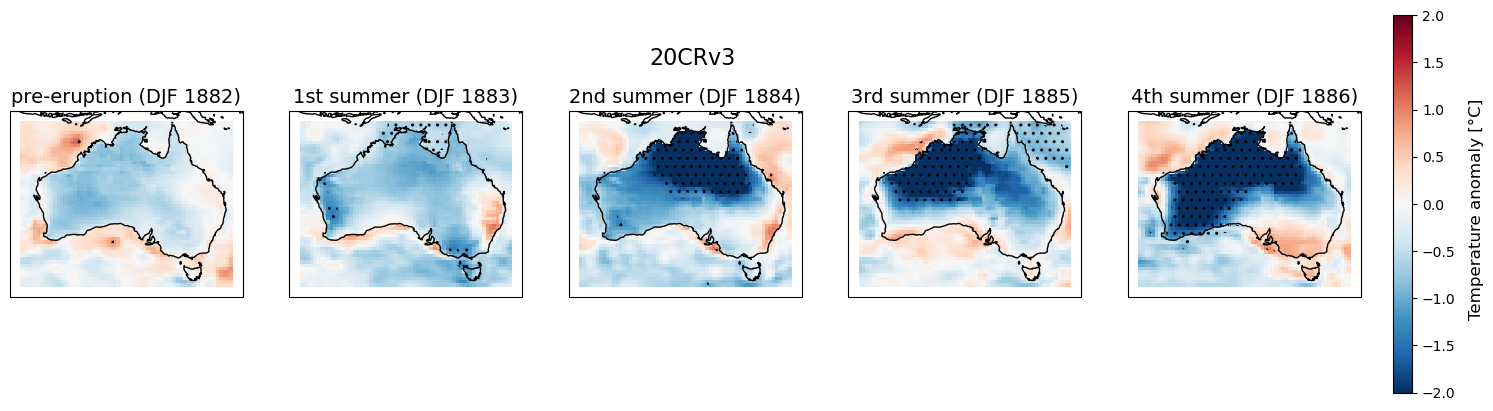

In [22]:
# plot of Australian monthly member mean temperature
label_loc=[4,-1.2]
cbar=[0.7, 0.02]
fig = func.spatial_plot_cv(1, 5, K_mmm_mon_Aus.tmp.sel(season='DJF'), cmax_tmp, K_dates_w, titles_s, 
                            'RdBu_r', f'Temperature anomaly [{deg}C]', 1, label_loc=label_loc, cbar=cbar)
# add title to figure
fig.suptitle('20CRv3', y=0.72, x=0.45, fontsize=16)

fig.set_figwidth(21)
fig.set_figheight(7)

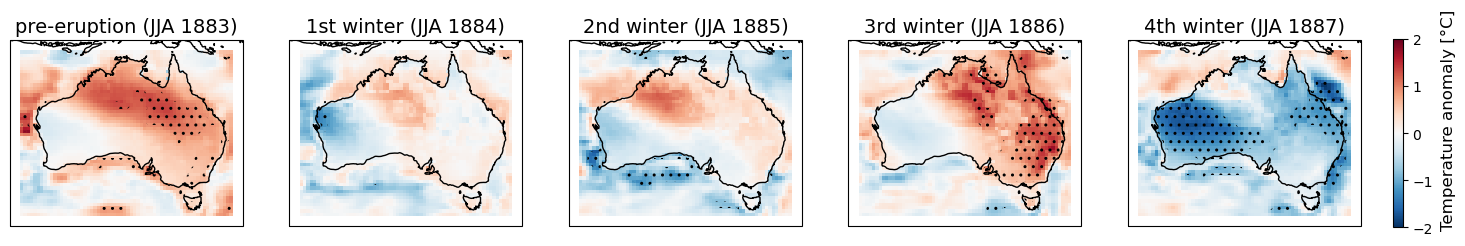

In [23]:
# plot of Australian monthly member mean temperature
label_loc=[5,-2.0]
fig = func.spatial_plot_cv(1, 5, K_mmm_mon_Aus.tmp.sel(season='JJA'), cmax_tmp, K_dates_w, titles_w, 
                            'RdBu_r', f'Temperature anomaly [{deg}C]', 1, label_loc)

fig.set_figwidth(21)
fig.set_figheight(7)

### Global plots

In [24]:
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels

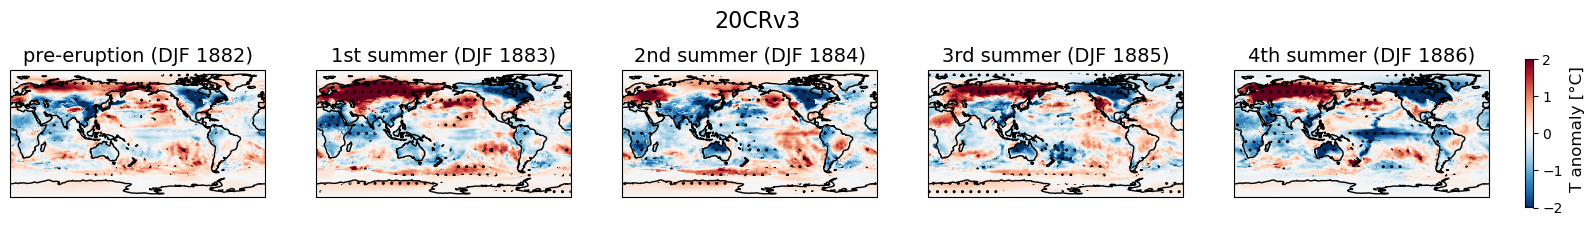

In [25]:
# plot of Global monthly member mean temperature
label_loc=[6,-1.5]
fig = func.spatial_plot_cv(1, 5, K_mmm_mon_Glob.tmp.sel(season='DJF'), cmax_tmp, K_dates_w, titles_s, 
                            'RdBu_r', f'T anomaly [{deg}C]', 1, label_loc)
# add title to figure
fig.suptitle('20CRv3', y=0.72, x=0.45, fontsize=16)

fig.set_figwidth(23)
fig.set_figheight(5.5) 

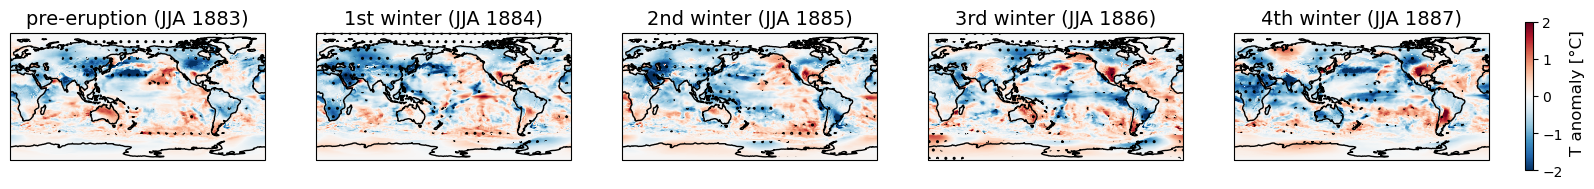

In [26]:
# plot of Global monthly member mean temperature
label_loc=[6,-1.5]
fig = func.spatial_plot_cv(1, 5, K_mmm_mon_Glob.tmp.sel(season='JJA'), cmax_tmp, K_dates_w, titles_w, 
                            'RdBu_r', f'T anomaly [{deg}C]', 1, label_loc)

fig.set_figwidth(23)
fig.set_figheight(5.5)